Fit the regression coefficients using the same GMM model we used for the iris data

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev import result_loading_utils

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

In [2]:
from bnpreg_runjingdev import genomics_data_utils

# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, gamma, _, regressors_transformed = \
    genomics_data_utils.load_and_tranform_data(bnp_data_repo)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [3]:
n_obs = gamma.shape[0]
dim = gamma.shape[1]

# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
alpha0 = 6.0
prior_params_dict['dp_prior_alpha'] = alpha0
print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float64)}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 50

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(gamma, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(81362.09053984, dtype=float64)

# Optimize KL objective

### Initialize with K-means

In [9]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    gmm_optim_lib.cluster_and_get_k_means_inits(gamma,
                                            vb_params_paragami, 
                                            n_kmeans_init = n_kmeans_init, 
                                            seed = 789970)

In [10]:
print('initial kl: ')
print(gmm_lib.get_kl(gamma, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
113487.02060908388


In [11]:
vb_params_dict = init_vb_params_dict

### Optimize the KL

In [12]:
vb_opt_dict, vb_opt, e_z_opt, out, _ = gmm_optim_lib.optimize_gmm(gamma,
                                                                 vb_params_dict,
                                                                 vb_params_paragami,
                                                                 prior_params_dict, 
                                                                 gh_loc, gh_weights, 
                                                                 run_newton = True)

compiling objective and derivatives ... 
done. Compile time: 64.549sec
Running L-BFGS-B ...
L-BFGS-B time: 97.237sec
Running trust-ncg ... 
Newton time: 140.735sec
Optimization terminated successfully.
done. 


In [13]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Check results

In [14]:
def get_e_num_obs_per_cluster(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(gamma, vb_params_dict,
                                                             gh_loc, gh_weights)
    
    return ez.sum(0)

In [15]:
def get_mixture_weights(vb_params_free): 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_params_dict, gh_loc, gh_weights)

In [16]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt)
mixture_weights = get_mixture_weights(vb_opt)

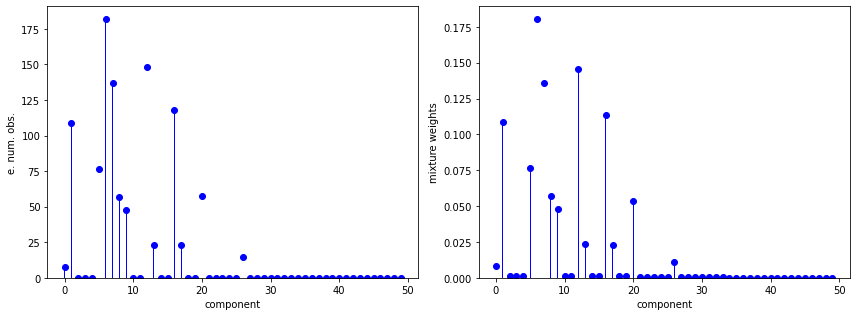

In [26]:
# plot mixture weights and allocations

fig, axarr = plt.subplots(1, 2, figsize = (12, 4.5))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


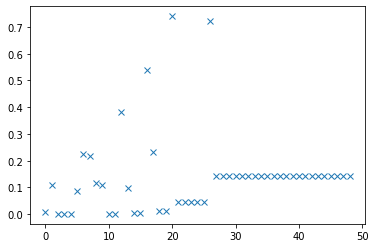

In [28]:
from bnpmodeling_runjingdev import exponential_families as ef

stick_means = ef.get_e_logitnormal(vb_opt_dict['stick_params']['stick_means'],
                              vb_opt_dict['stick_params']['stick_infos'],
                              gh_loc, gh_weights)

plt.plot(stick_means, 'x')

In [20]:
import regression_plotting_utils

In [18]:
top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)

In [19]:
centroids = vb_opt_dict['cluster_params']['centroids']

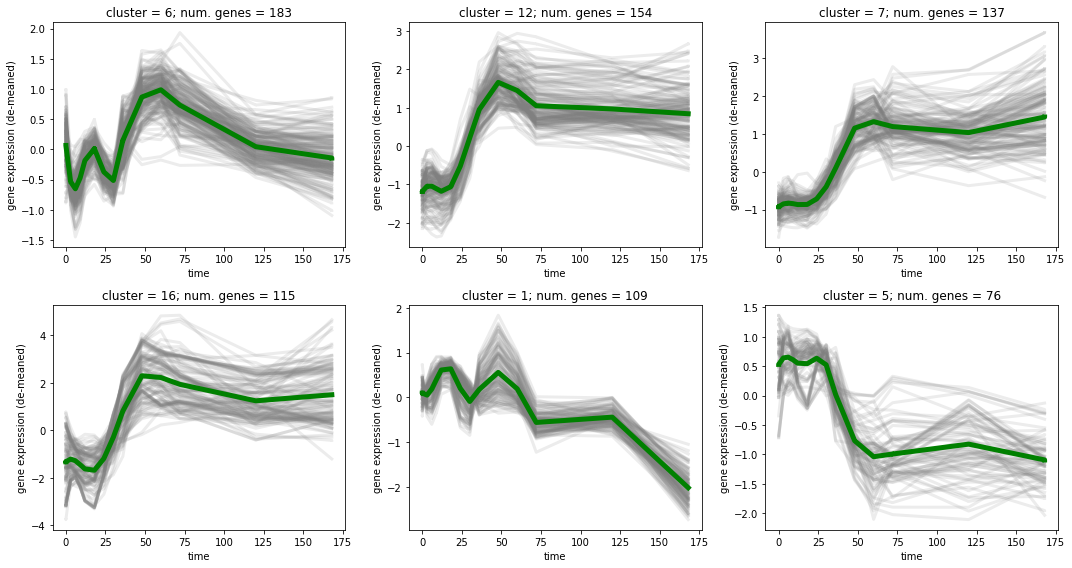

In [21]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    which_cluster = top_clusters_sorted[i]
    which_genes = np.argwhere(e_z_opt.argmax(1) == which_cluster).squeeze()
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')

    # Plot genes in this cluster
    for n in which_genes: 
        regression_plotting_utils.plot_prediction_line(timepoints, 
                                                       regressors_transformed, 
                                                       gamma[n], 
                                                       ax = this_plot, 
                                                       alpha = 0.15, 
                                                       color = 'grey')
        
    # plot centroid
    regression_plotting_utils.plot_prediction_line(timepoints, 
                                                   regressors_transformed, 
                                                   centroids[which_cluster], 
                                                   ax = this_plot, 
                                                   linewidth = 5, 
                                                   color = 'green')
    


f.tight_layout()
